In [87]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np
from nltk.stem import WordNetLemmatizer

# Đọc dữ liệu từ file CSV
file_path = '/content/Restaurant reviews.csv'
res_review = pd.read_csv(file_path, encoding='ISO-8859-1')

# Drop các cột không cần thiết
columns_to_drop = ['Time', 'Pictures', '7514','Metadata']
res_review = res_review.drop(columns_to_drop, axis=1)

# Xóa các hàng có cột 'Rating' hoặc 'Review' bị thiếu
res_review.dropna(subset=['Rating', 'Review'], inplace=True)




In [88]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

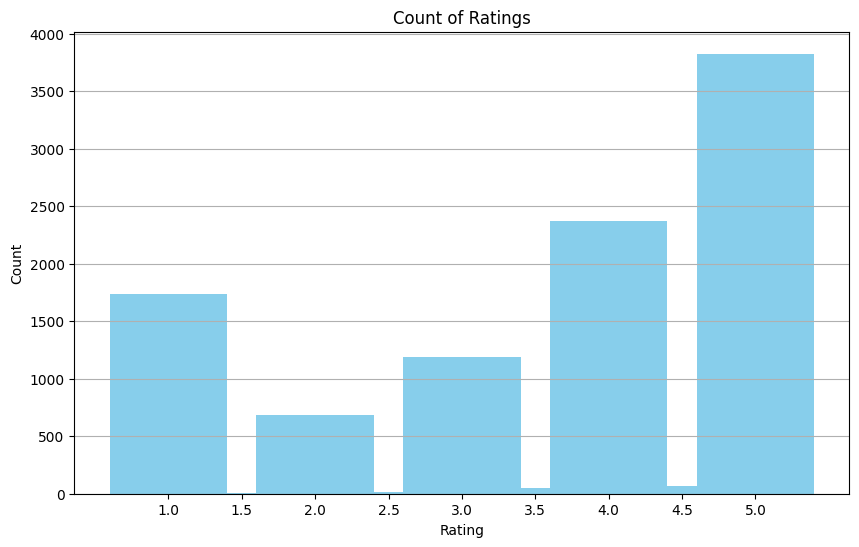

In [89]:
rating_counts = res_review["Rating"].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.bar(rating_counts.index, rating_counts.values, color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Count of Ratings')
plt.xticks(rating_counts.index)
plt.grid(axis='y')
plt.show()

In [90]:

# Điều chỉnh cột Rating thành labels
res_review['Rating'] = res_review['Rating'].astype(float)
labels = []
for i in res_review['Rating']:
    if i >= 3:
        labels.append(1)
    else:
        labels.append(0)

# Thêm cột labels vào DataFrame
res_review['Labels'] = labels


# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_data, test_data = train_test_split(res_review, test_size=0.2, random_state=42)

# Lấy ra các câu huấn luyện và nhãn tương ứng
training_sentences = train_data['Review'].tolist()
training_labels = train_data['Labels'].tolist()
testing_sentences = test_data['Review'].tolist()
testing_labels = test_data['Labels'].tolist()

lemmatizer = WordNetLemmatizer()
def clean_text(text):
    # Loại bỏ các ký tự đặc biệt nhưng giữ lại dấu phẩy, dấu chấm, dấu cảm thán và dấu hỏi
    text = re.sub(r"[^a-zA-Z0-9\s.,!?]", '', text)

    # Loại bỏ các dấu chấm hoặc dấu phẩy lặp lại liên tục
    text = re.sub(r"\.{2,}", '.', text)
    text = re.sub(r",,{2,}", ',', text)

    # Viết hoa chữ cái đầu mỗi câu sau dấu chấm
    sentences = text.split('.')
    sentences = [sentence.strip().capitalize() for sentence in sentences if sentence.strip()]
    text = '. '.join(sentences)

    # Loại bỏ những từ lặp và chỉ giữ lại một từ của từ lặp đó
    words = text.split()
    unique_words = []
    for word in words:
        simplified_word = ''.join(sorted(set(word), key=word.index))  # Loại bỏ các ký tự lặp
        unique_words.append(simplified_word)
    text = ' '.join(unique_words)

    # Lemmatize words
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in words]


    # Xử lý từ phủ định và từ cảm thán
    negation_words = {"not", "no", "never","worst"}
    exclamation_words = {"wow", "yay", "oh","extremely",}

    words = text.split()
    processed_words = []
    skip_next = False
    for i, word in enumerate(lemmatized_words):
        if skip_next:
            skip_next = False
            continue
        if word in negation_words and i + 1 < len(lemmatized_words):
            processed_words.append("NOT_" + lemmatized_words[i + 1])
            skip_next = True
        elif word in exclamation_words:
            processed_words.append(word.upper())
        else:
            processed_words.append(word)
    # Join words back into sentence
    clean_sentence = ' '.join(processed_words)

    return clean_sentence

# Áp dụng hàm clean_text cho các câu trong tập huấn luyện và kiểm tra
training_sentences_cleaned = [clean_text(sentence) for sentence in training_sentences]
testing_sentences_cleaned = [clean_text(sentence) for sentence in testing_sentences]



In [91]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')

stemmer = PorterStemmer()

def stem_sentence(sentence):
    words = word_tokenize(sentence)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Áp dụng stemming cho các câu trong tập huấn luyện và kiểm tra
training_sentences_stemmed = [stem_sentence(sentence) for sentence in training_sentences]
testing_sentences_stemmed = [stem_sentence(sentence) for sentence in testing_sentences]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [92]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000  # Kích thước từ điển
max_len = 100 # Độ dài tối đa của các câu

# Khởi tạo Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(training_sentences_stemmed)

# Tokenize dữ liệu huấn luyện và kiểm tra
training_sequences = tokenizer.texts_to_sequences(training_sentences_stemmed)
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding='post', truncating='post')

#áp dụng padding cho chuỗi dữ liệu được tokenize
testing_sequences = tokenizer.texts_to_sequences(testing_sentences_stemmed)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding='post', truncating='post')


In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np

embedding_dim = 100  # Kích thước của embedding

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    LSTM(64),
      Dense(24, activation='relu'),
      Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

num_epochs = 20
batch_size = 16
history = model.fit(training_padded, np.array(training_labels),batch_size=batch_size, epochs=num_epochs, validation_data=(testing_padded, np.array(testing_labels)), verbose=2)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 100)          1000000   
                                                                 
 lstm_13 (LSTM)              (None, 64)                42240     
                                                                 
 dense_24 (Dense)            (None, 24)                1560      
                                                                 
 dense_25 (Dense)            (None, 1)                 25        
                                                                 
Total params: 1043825 (3.98 MB)
Trainable params: 1043825 (3.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
498/498 - 31s - loss: 0.5610 - accuracy: 0.7554 - val_loss: 0.5589 - val_accuracy: 0.7484 - 31s/epoch - 63ms/step
Epoch 2/20
498/498 - 8

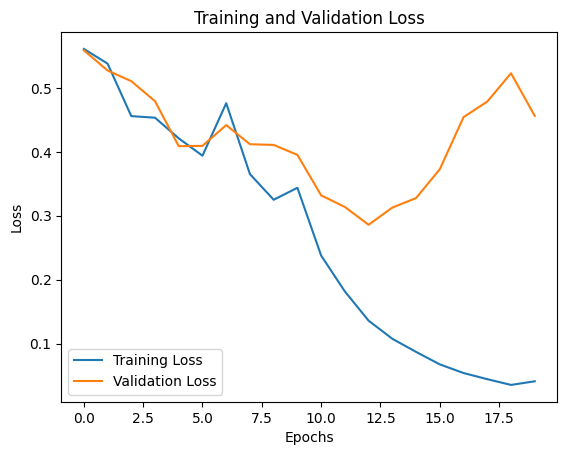

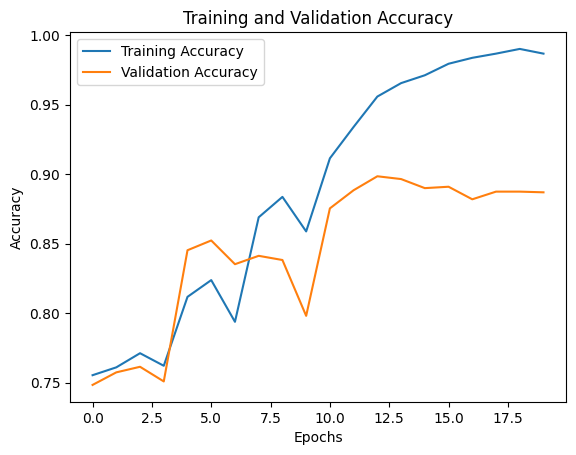

In [94]:
import matplotlib.pyplot as plt

# Biểu đồ loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Biểu đồ accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [95]:
def predict_review(model, review):
    stemmed_review = stem_sentence(review)
    sequence = tokenizer.texts_to_sequences([stemmed_review])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    prediction = model.predict(padded)
    return 'Tốt' if prediction[0] > 0.5 else 'Không tốt'

# Ví dụ sử dụng cho 1 review 2 sao
review = "The hotel staffs is rude, I need to wait very long for the food"
print(predict_review(model, review))


1/1 [==============================] - 0s 355ms/step
Không tốt
